In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose


In [60]:
df = pd.read_csv("../data/CPI.csv")
df['Date'] = pd.to_datetime(df['Date'], format='%m/%Y')
df.set_index('Date', inplace=True)
plt.figure(figsize=(12, 6))
plt.plot(df['Value'], linestyle='-')
plt.title('Value Over Time to Check for Seasonality')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True)
plt.show()

,Value,Change
Date,,
2002-01-01,101.10,0.00
2002-02-01,102.20,1.10
2002-03-01,99.20,-3.00
2002-04-01,100.00,0.80
2002-05-01,100.30,0.30
...,...,...
2022-08-01,100.00,-0.40
2022-09-01,100.40,0.40
2022-10-01,100.15,-0.25


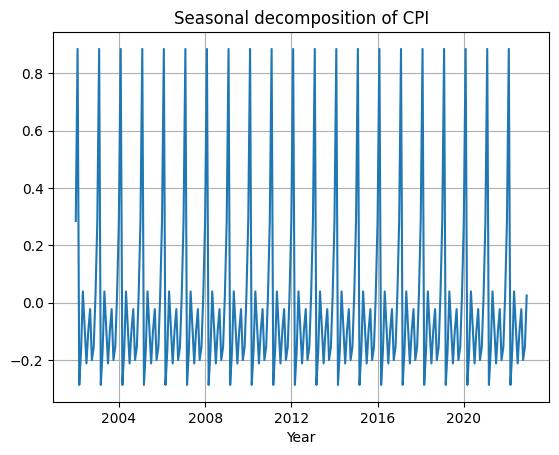

In [63]:
result = seasonal_decompose(df['Value'], model='additive', period=12)  # Assuming monthly data and yearly seasonality
plt.plot(result.seasonal)
plt.title("Seasonal decomposition of CPI")
plt.xlabel("Year")
plt.grid(True)
plt.show()

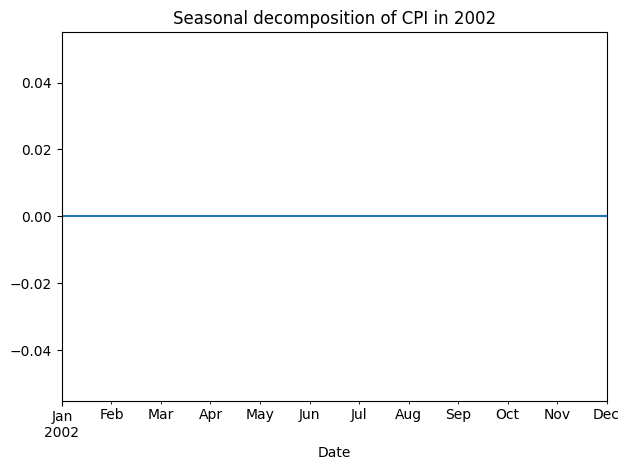

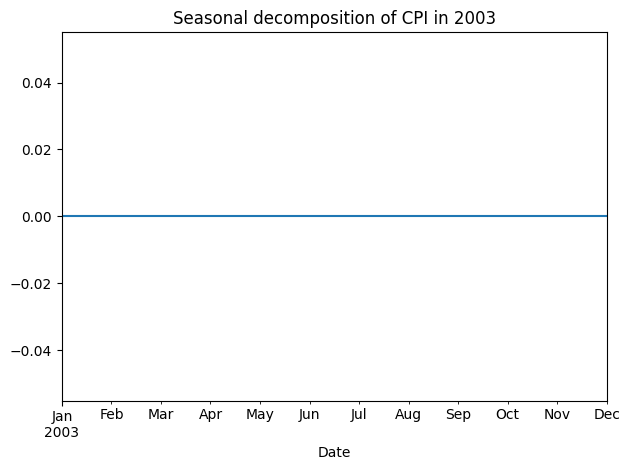

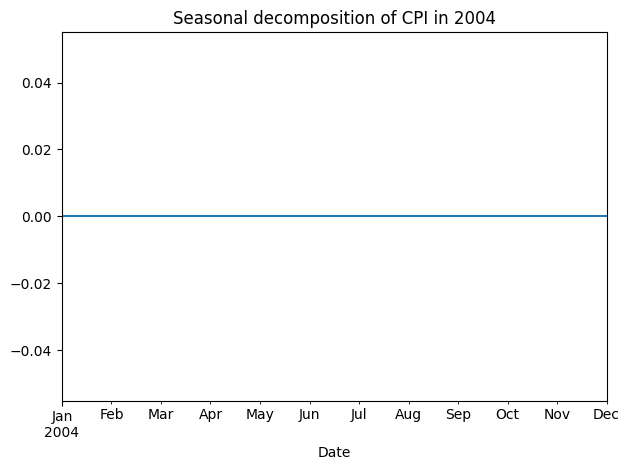

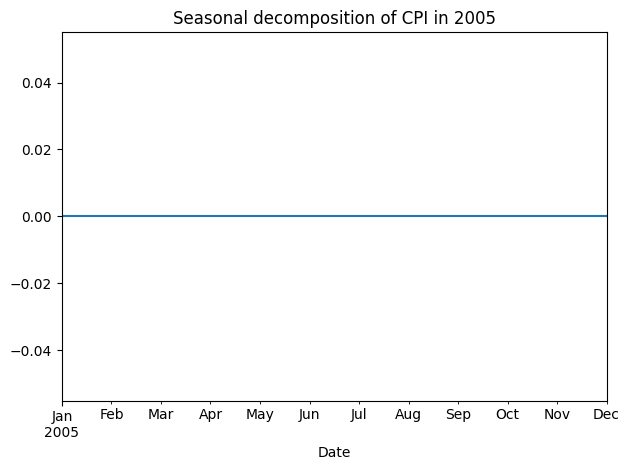

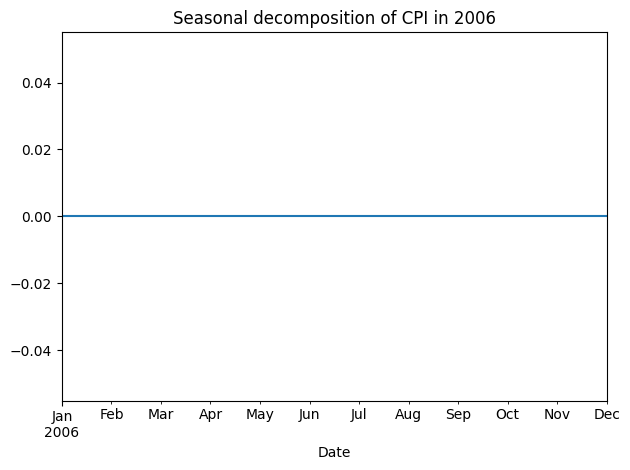

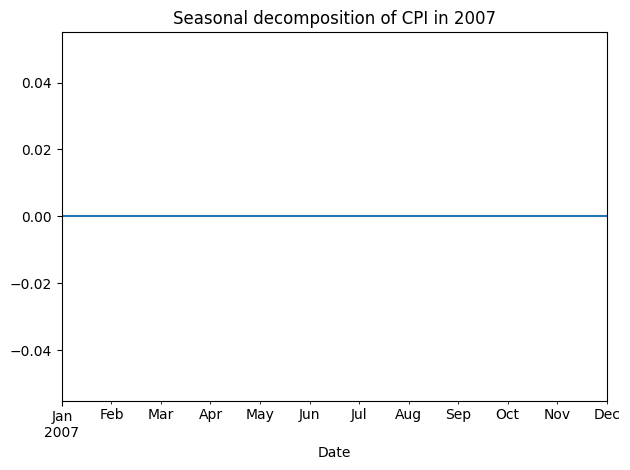

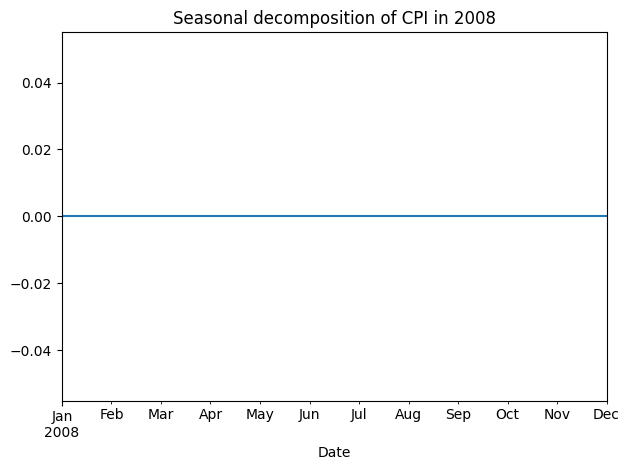

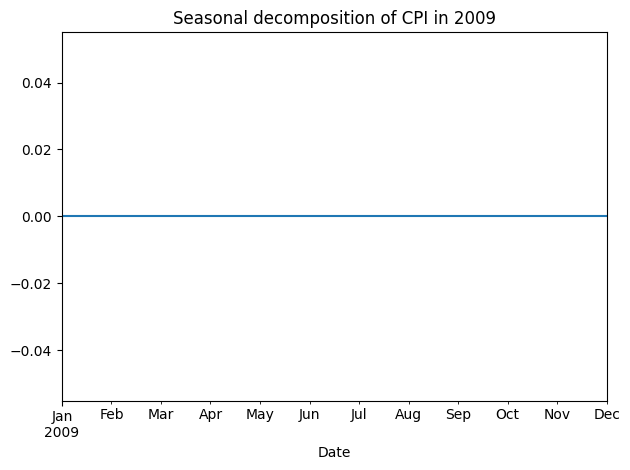

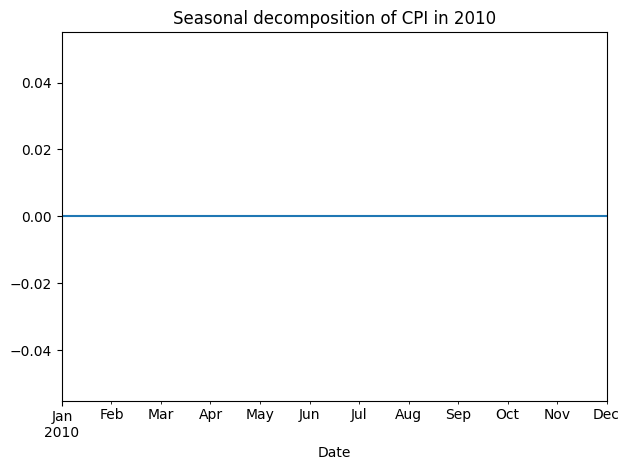

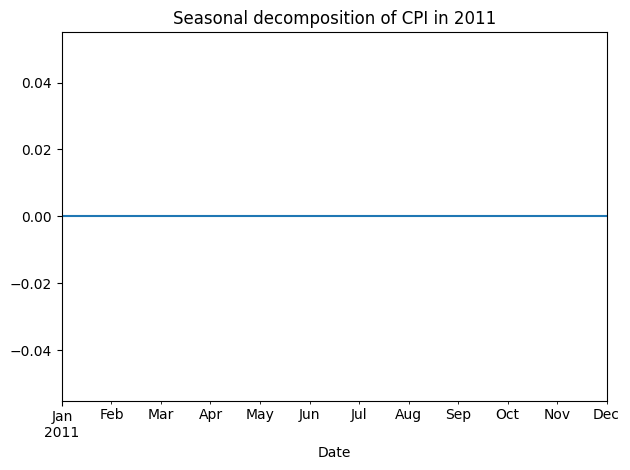

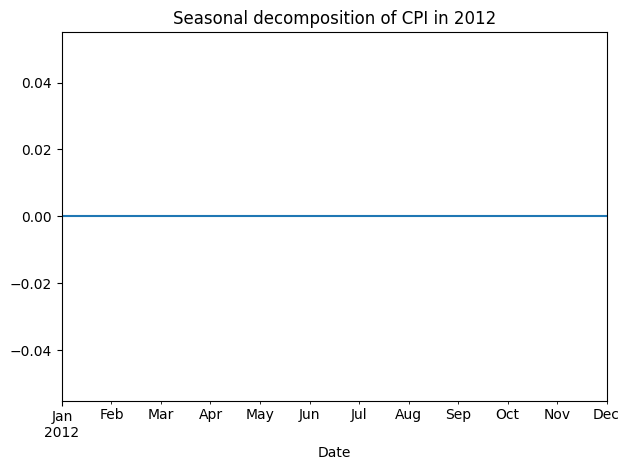

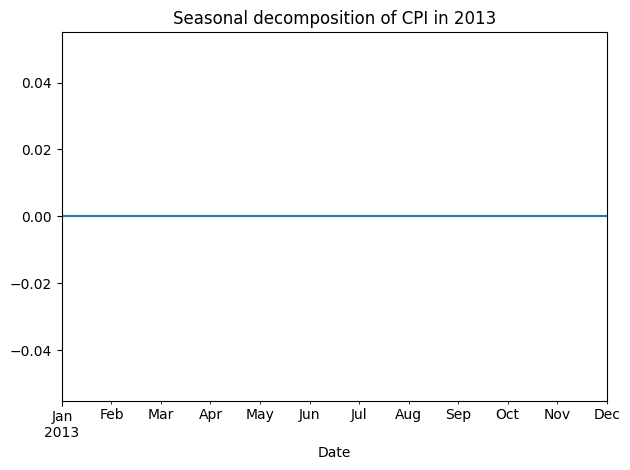

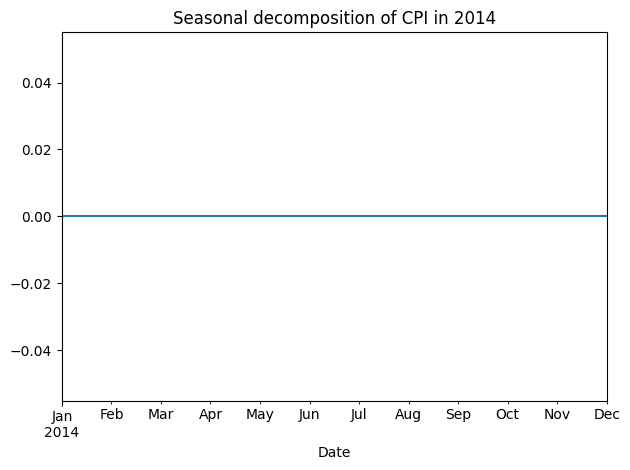

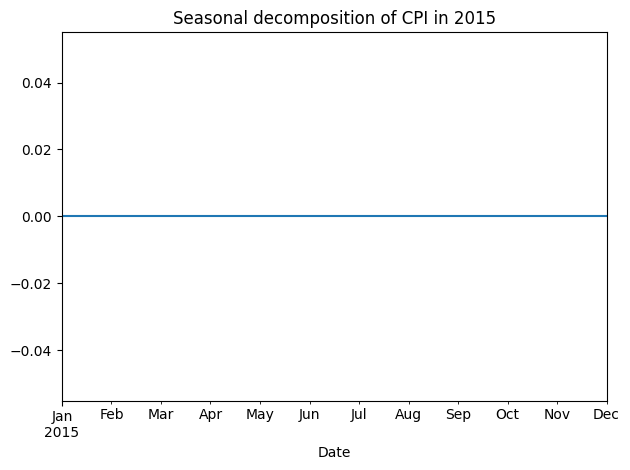

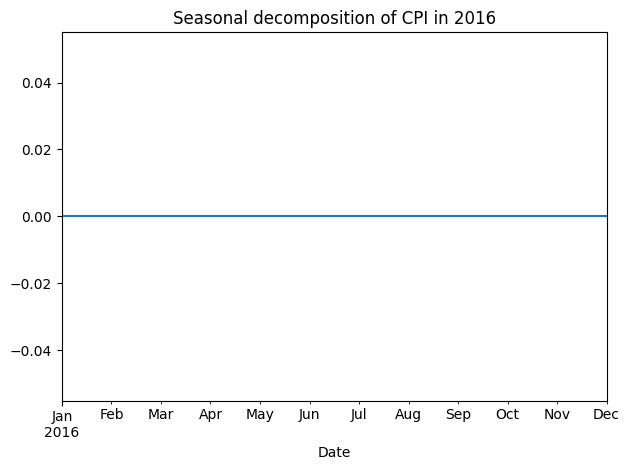

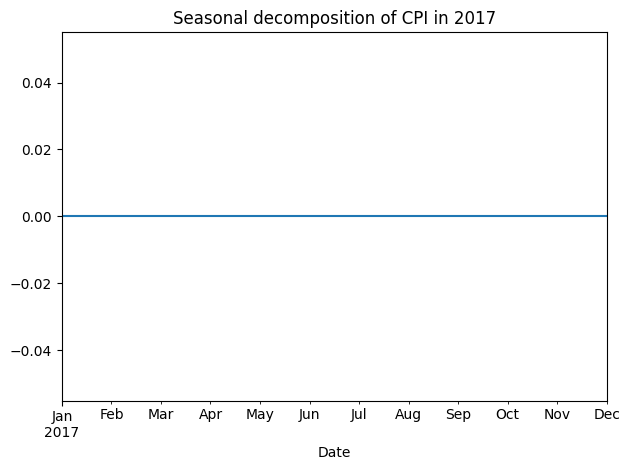

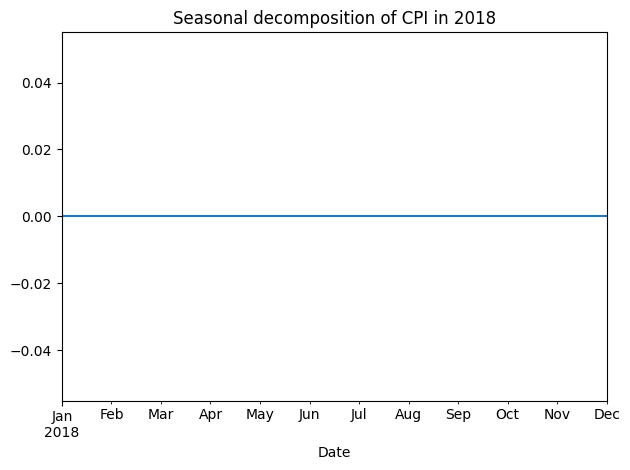

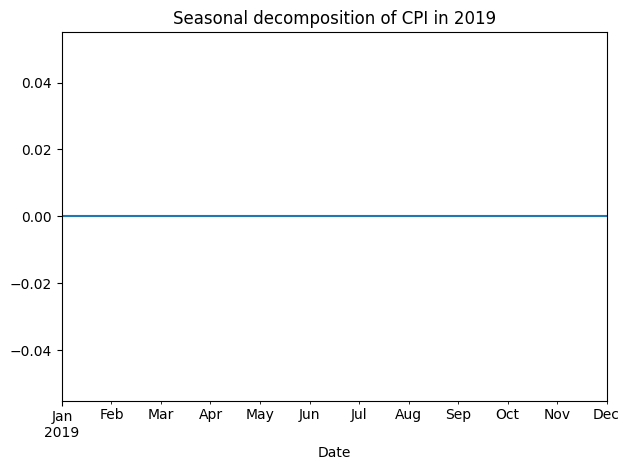

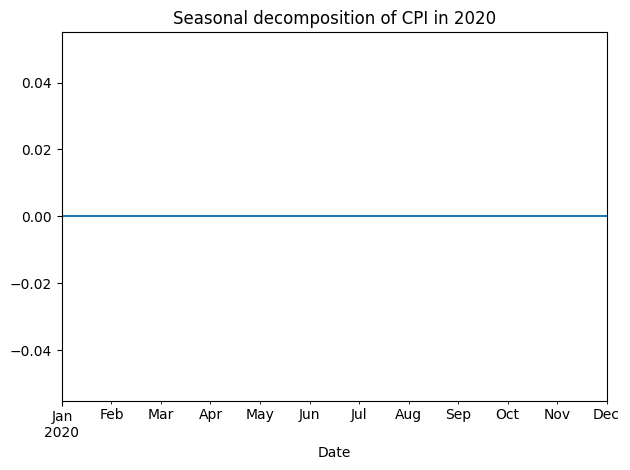

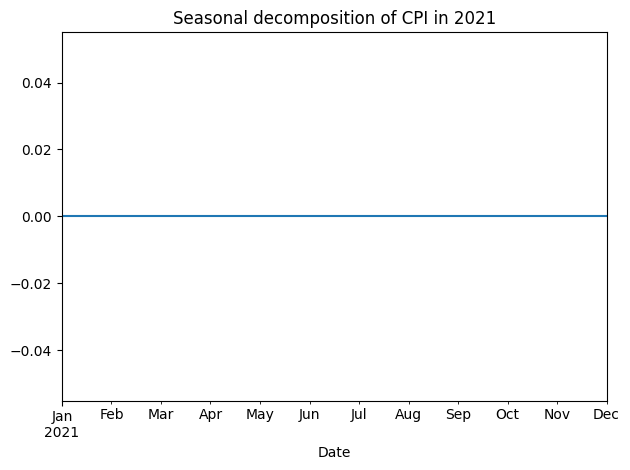

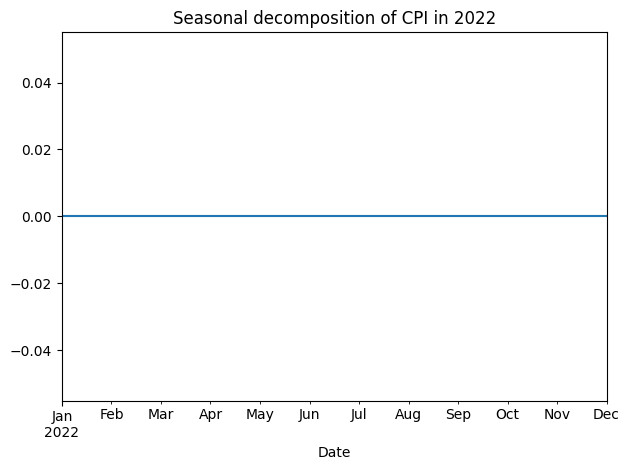

In [65]:
from statsmodels.tsa.seasonal import seasonal_decompose
for i in range(21):
    result = seasonal_decompose(df[i * 12:(i + 1) * 12]['Value'], model='additive', period=1)  # Assuming monthly data and yearly seasonality
    result.seasonal.plot()
    plt.title(f"Seasonal decomposition of CPI in {i + 2002}")
    plt.tight_layout()
    plt.savefig(f"../out/img/seasonal/CPI/{i + 2002}")
    plt.show()